In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [15]:
import joblib 
from sklearn.preprocessing import MinMaxScaler 
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
path = r'../dataset/dataset_v2.csv'    
df = pd.read_csv(path, parse_dates=['Date'])
df = df.sort_values("Date")
df = df.reset_index(drop=True)
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev
0,2000-08-31,278.299988,0.0,172.7,6.50,1517.680054,112.599998,273.899994,273.899994,273.899994
1,2000-09-01,277.000000,0.0,173.6,6.52,1520.770020,111.419998,274.799988,278.299988,274.799988
2,2000-09-05,275.799988,2.0,173.6,6.52,1507.079956,112.410004,277.000000,277.000000,277.000000
3,2000-09-06,274.200012,0.0,173.6,6.52,1492.250000,114.120003,275.799988,275.799988,275.799988
4,2000-09-07,274.000000,125.0,173.6,6.52,1502.510010,113.650002,274.200012,274.200012,274.200012


2. Feature engineering

In [11]:
df.columns

Index(['Date', 'Close', 'Volume', 'CPIAUCSL', 'FEDFUNDS', 'sp500', 'usd_index',
       'Open_prev', 'High_prev', 'Low_prev'],
      dtype='object')

In [12]:
cols_to_lag = [
    'Close'
]

In [13]:
def add_rolling_features(df, col, windows=[3,7]):
    for w in windows:
        df[f"{col}_roll_mean{w}"] = df[col].rolling(w).mean()
        df[f"{col}_roll_std{w}"] = df[col].rolling(w).std()

In [14]:
for col in cols_to_lag:
    add_rolling_features(df, col)

df = df.dropna()

print(f'Length of the dataset is: {len(df)}')

df.head()

Length of the dataset is: 6212


,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,Close_roll_mean3,Close_roll_std3,Close_roll_mean7,Close_roll_std7
6,2000-09-11,273.100006,0.0,173.6,6.52,1489.260010,115.370003,273.299988,273.299988,273.299988,273.466665,0.472581,275.099997,1.983259
7,2000-09-12,272.899994,0.0,173.6,6.52,1481.989990,115.169998,273.100006,273.100006,273.100006,273.099996,0.199997,274.328570,1.529394
8,2000-09-13,272.799988,0.0,173.6,6.52,1484.910034,115.339996,272.899994,272.899994,272.899994,272.933329,0.152762,273.728568,1.057850
9,2000-09-14,272.399994,0.0,173.6,6.52,1480.869995,115.160004,272.799988,272.799988,272.799988,272.699992,0.264574,273.242855,0.650281
10,2000-09-15,272.299988,0.0,173.6,6.52,1465.810059,115.940002,272.399994,272.399994,272.399994,272.499990,0.264574,272.971422,0.576528


3. Scaling the values

In [16]:
target = ['Close']
features = [col for col in df.columns if col not in ['Date', target]]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

path = r'../scalers/scaler3.pkl'
joblib.dump(scaler, path)

['../scalers/scaler3.pkl']

In [17]:
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,Close_roll_mean3,Close_roll_std3,Close_roll_mean7,Close_roll_std7
6,2000-09-11,0.005667,0.0,0.0,1.0,0.148644,0.888441,0.005742,0.005326,0.005805,0.005400,0.004533,0.005542,0.014198
7,2000-09-12,0.005604,0.0,0.0,1.0,0.147315,0.884406,0.005679,0.005264,0.005742,0.005283,0.001918,0.005295,0.010361
8,2000-09-13,0.005573,0.0,0.0,1.0,0.147849,0.887835,0.005617,0.005202,0.005678,0.005230,0.001465,0.005103,0.006374
9,2000-09-14,0.005447,0.0,0.0,1.0,0.147110,0.884204,0.005585,0.005171,0.005647,0.005156,0.002538,0.004947,0.002928
10,2000-09-15,0.005415,0.0,0.0,1.0,0.144355,0.899939,0.005460,0.005047,0.005520,0.005093,0.002538,0.004861,0.002305


4. Training the model

In [18]:
X = df[features]
y = df[target]

split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [19]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R² Score: -0.4100
Mean Squared Error: 0.0234


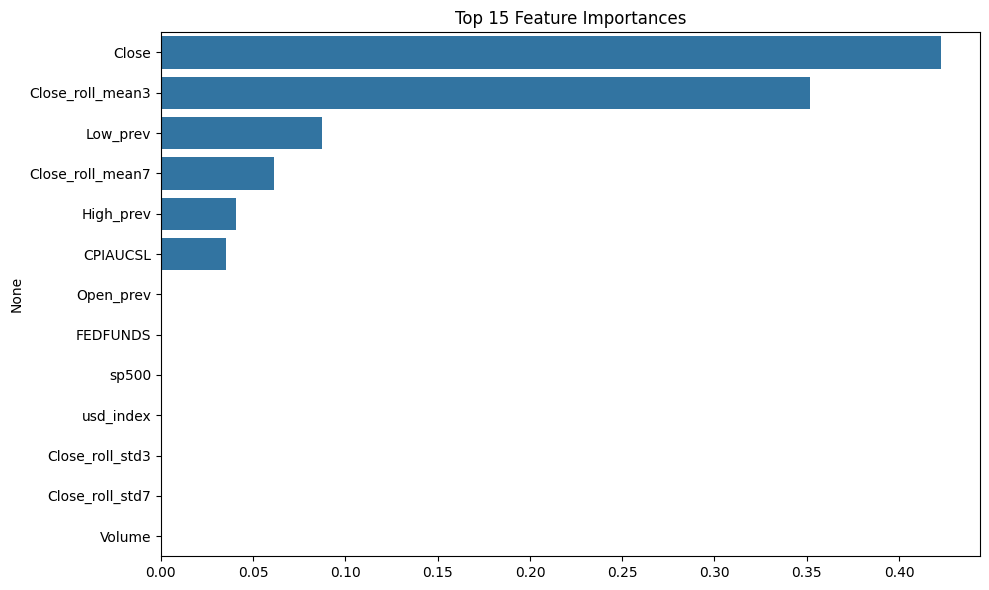

In [21]:
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

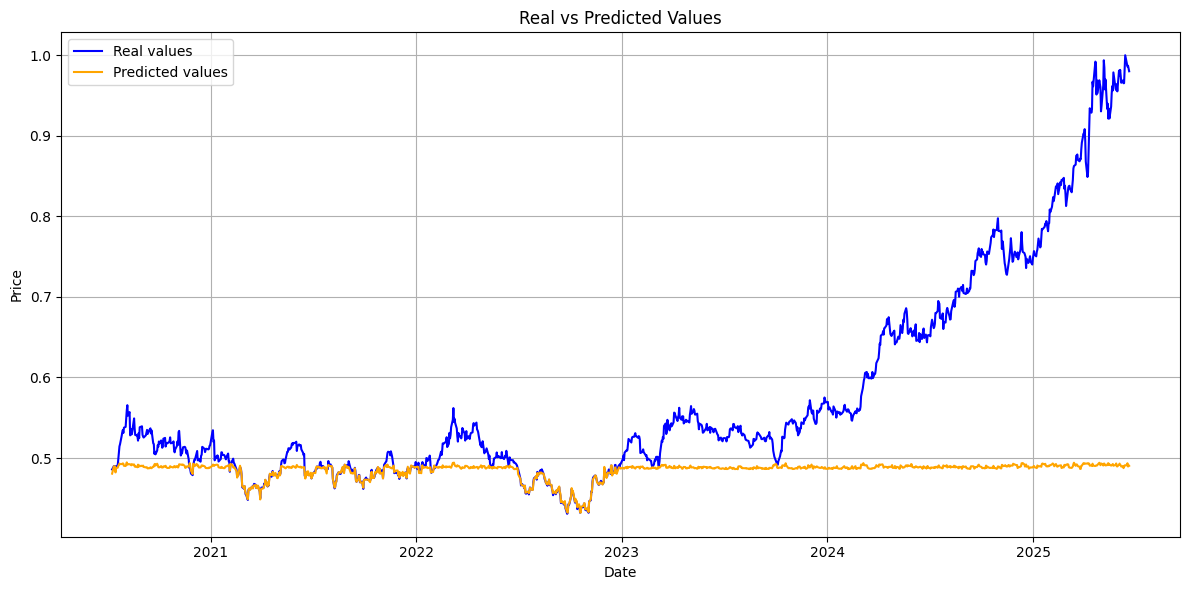

In [22]:
df['Date'] = pd.to_datetime(df['Date'])

date_test = df['Date'].iloc[split_index:]

plt.figure(figsize=(12, 6))
plt.plot(date_test, y_test, label='Real values', color='blue')
plt.plot(date_test, y_pred, label='Predicted values', color='orange')

plt.title('Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()